In [17]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
print("This is working!")

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
    
    
fetch_housing_data()
housing = load_housing_data()
housing.head()

This is working!


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [18]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [19]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [20]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


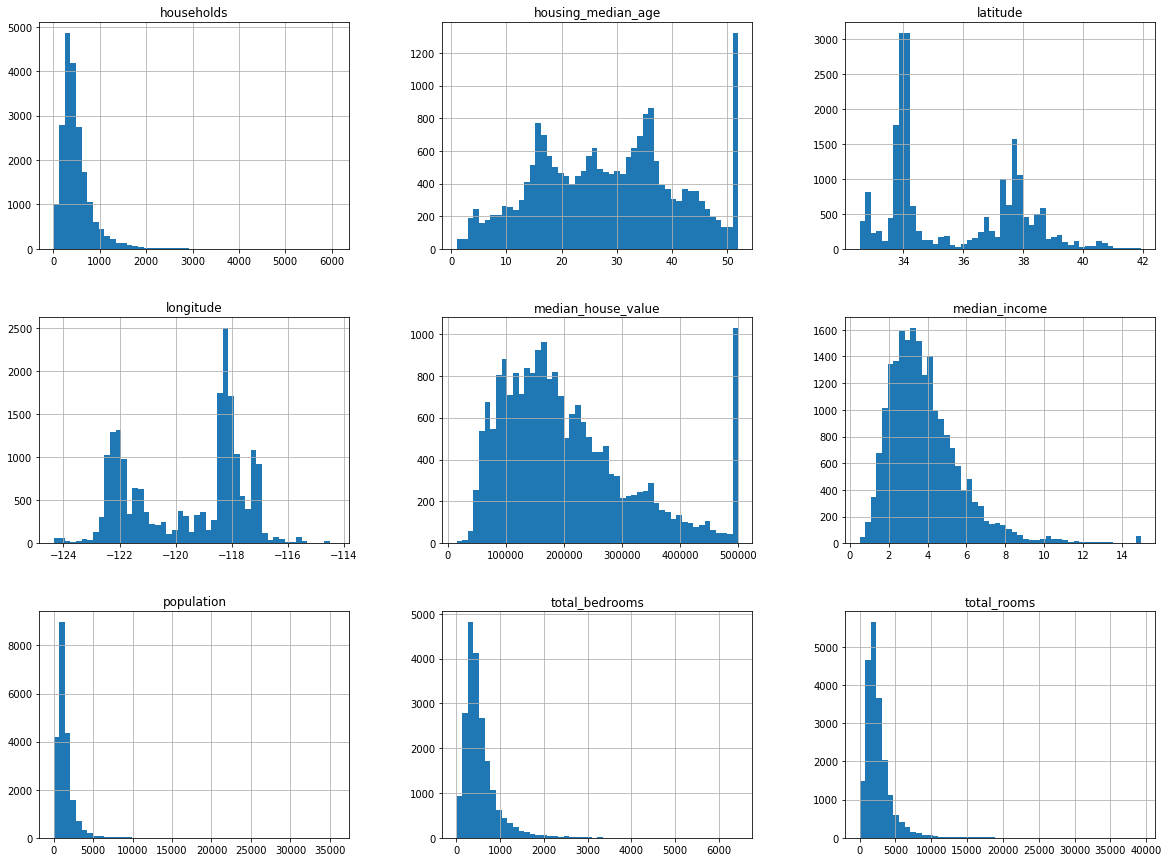

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [29]:
import numpy as np

# Over time this will run through the whole dataset. Solution is to save the test set on the first run.
# Another is to set the random number generator's seed (e.g. np.random.seed(42)) before calling np.random.permutation()
# Both of the above will break when an updated dataset is fetched

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [30]:
# Another method is to use each instance's identifier to decide whether or not it should go in the test set
# i.e. compute hash of each instance's identifier and put that instance in the test set if hash <= 20% of max hash value

# example code for this:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# Housing dataset has no identifier column, need an index

housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [32]:
# When using the row index ID as above, need to ensure new data is appended to the end of the dataset
# Don't want rows deleted
# If this is not possible, can use the most stable feature to build a unique ID - in this case Long. & Lat.

housing_with_id_addition = housing_with_id
housing_with_id_addition["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id_addition, 0.2, "id")

# Implementation using Scikit-Learn instead of the function from scratch

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


# All of the above are random sampling methods. Generally fine with large datasets,, however, with smaller data sets
# there is risk of sampling bias
                                                    

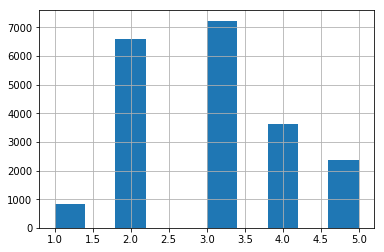

In [39]:
# Suppose that median income is deemed an important feature in the prediction of median housing prices
# The histogram below shows that there is a significant clustering from 2-5 ($20K - $50K):

#housing["median_income"].hist(bins=50, figsize=(20,15))
#plt.show()

# In order to use median income as a predictor for housing prices we will want to create catergorical values
# Divide median income by 1.5 to limit the number of income categories, rounds up using numpy.ceil()

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

# Histgram shows new median_income:

housing["income_cat"].hist()
plt.show()



In [48]:
# Now ready to do Stratified sampling, based on the income category
# Use Scikit-Learn's StratifiedShuffleSplit class:

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [49]:
# Shows proportions of income category in the test set w/ stratified sampling. Once again, this is useful
# when using small data sets where randomized sampling my skew the proportions
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [51]:
# Set the data back to its original state by removing 'income_cat'

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
# A lot of time spent on test set generation, an often neglected but critical part of ML projects. Will re-use these
# concepts when doing cross validation

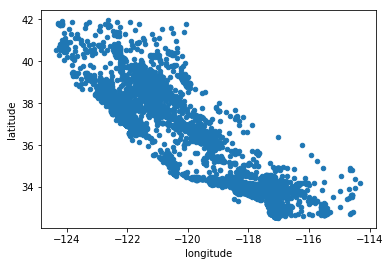

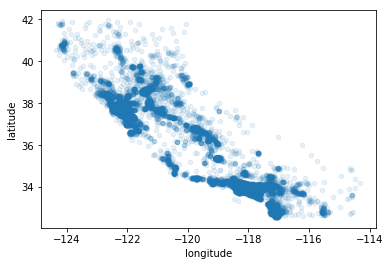

In [55]:
# Data Exploration (EDA)
# Only want to be exploring the training set here.
# If training set is very large, can be useful to set aside smaller, exploration set to make manipulations faster
# Create a copy of the training set

housing = strat_train_set.copy()

# Visualizing Geographical Data - Create Scatter plots

housing.plot(kind="scatter", x="longitude", y="latitude")

# Set alpha option to 0.1 to make it easier to visualize higher density points

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)